In [1]:
import fastf1 as ff1
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm

from fastf1 import plotting

# Enable the cache
ff1.Cache.enable_cache('cache')
# Get rid of an error
pd.options.mode.chained_assignment = None

In [4]:
# Load the session data
year = 2024
circuit = 'Bahrain'
session = 'R'

race = ff1.get_session(year, circuit, session)
# Get the laps
race.load(telemetry=True, laps=True, weather=False)
laps = race.laps

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No ca

In [8]:
race.results.columns
race.results[['Abbreviation', 'TeamName', 'TeamId', 'ClassifiedPosition','Time', 'Status',]]


,Abbreviation,TeamName,TeamId,ClassifiedPosition,Time,Status
1,VER,Red Bull Racing,red_bull,1,0 days 01:31:44.742000,Finished
11,PER,Red Bull Racing,red_bull,2,0 days 00:00:22.457000,Finished
55,SAI,Ferrari,ferrari,3,0 days 00:00:25.110000,Finished
16,LEC,Ferrari,ferrari,4,0 days 00:00:39.669000,Finished
63,RUS,Mercedes,mercedes,5,0 days 00:00:46.788000,Finished
4,NOR,McLaren,mclaren,6,0 days 00:00:48.458000,Finished
44,HAM,Mercedes,mercedes,7,0 days 00:00:50.324000,Finished
81,PIA,McLaren,mclaren,8,0 days 00:00:56.082000,Finished
14,ALO,Aston Martin,aston_martin,9,0 days 00:01:14.887000,Finished
18,STR,Aston Martin,aston_martin,10,0 days 00:01:33.216000,Finished


In [40]:
# Convert laptimes to seconds
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# To get accurate laps only, we exclude in- and outlaps
laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]

In [41]:
# Also, we remove outliers since those don't represent the racepace,
# using the Inter-Quartile Range (IQR) proximity rule
q75, q25 = laps['LapTimeSeconds'].quantile(0.75), laps['LapTimeSeconds'].quantile(0.25)

intr_qr = q75 - q25

laptime_max = q75 + (1.5 * intr_qr) # IQR proximity rule: Max = q75 + 1,5 * IQR
laptime_min = q25 - (1.5 * intr_qr) # IQR proximity rule: Min = q25 + 1,5 * IQR

laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

In [42]:
laps.head()

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTimeSeconds
0,0 days 00:57:41.632000,VER,1,0 days 00:01:34.725000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:41.962000,...,Red Bull Racing,0 days 00:56:06.651000,2025-04-06 05:03:47.081,1,1.0,False,,False,False,94.725
1,0 days 00:59:15.575000,VER,1,0 days 00:01:33.943000,2.0,1.0,NaT,NaT,0 days 00:00:33.894000,0 days 00:00:42.026000,...,Red Bull Racing,0 days 00:57:41.632000,2025-04-06 05:05:22.062,1,1.0,False,,False,True,93.943
2,0 days 01:00:49.214000,VER,1,0 days 00:01:33.639000,3.0,1.0,NaT,NaT,0 days 00:00:33.567000,0 days 00:00:42.027000,...,Red Bull Racing,0 days 00:59:15.575000,2025-04-06 05:06:56.005,1,1.0,False,,False,True,93.639
3,0 days 01:02:22.958000,VER,1,0 days 00:01:33.744000,4.0,1.0,NaT,NaT,0 days 00:00:33.570000,0 days 00:00:42.140000,...,Red Bull Racing,0 days 01:00:49.214000,2025-04-06 05:08:29.644,1,1.0,False,,False,True,93.744
4,0 days 01:03:56.734000,VER,1,0 days 00:01:33.776000,5.0,1.0,NaT,NaT,0 days 00:00:33.486000,0 days 00:00:42.157000,...,Red Bull Racing,0 days 01:02:22.958000,2025-04-06 05:10:03.388,1,1.0,False,,False,True,93.776


In [43]:
race.results

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,CountryCode,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points
1,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671C6,red_bull,Max,Verstappen,Max Verstappen,...,,1.0,1,1.0,NaT,NaT,NaT,0 days 01:22:06.983000,Finished,25.0
4,4,L NORRIS,NOR,norris,McLaren,FF8000,mclaren,Lando,Norris,Lando Norris,...,,2.0,2,2.0,NaT,NaT,NaT,0 days 00:00:01.423000,Finished,18.0
81,81,O PIASTRI,PIA,piastri,McLaren,FF8000,mclaren,Oscar,Piastri,Oscar Piastri,...,,3.0,3,3.0,NaT,NaT,NaT,0 days 00:00:02.129000,Finished,15.0
16,16,C LECLERC,LEC,leclerc,Ferrari,E80020,ferrari,Charles,Leclerc,Charles Leclerc,...,,4.0,4,4.0,NaT,NaT,NaT,0 days 00:00:16.097000,Finished,12.0
63,63,G RUSSELL,RUS,russell,Mercedes,27F4D2,mercedes,George,Russell,George Russell,...,,5.0,5,5.0,NaT,NaT,NaT,0 days 00:00:17.362000,Finished,10.0
12,12,K ANTONELLI,ANT,antonelli,Mercedes,27F4D2,mercedes,Kimi,Antonelli,Kimi Antonelli,...,,6.0,6,6.0,NaT,NaT,NaT,0 days 00:00:18.671000,Finished,8.0
44,44,L HAMILTON,HAM,hamilton,Ferrari,E80020,ferrari,Lewis,Hamilton,Lewis Hamilton,...,,7.0,7,8.0,NaT,NaT,NaT,0 days 00:00:29.182000,Finished,6.0
6,6,I HADJAR,HAD,hadjar,Racing Bulls,6692FF,rb,Isack,Hadjar,Isack Hadjar,...,,8.0,8,7.0,NaT,NaT,NaT,0 days 00:00:37.134000,Finished,4.0
23,23,A ALBON,ALB,albon,Williams,64C4FF,williams,Alexander,Albon,Alexander Albon,...,,9.0,9,9.0,NaT,NaT,NaT,0 days 00:00:40.367000,Finished,2.0
87,87,O BEARMAN,BEA,bearman,Haas F1 Team,B6BABD,haas,Oliver,Bearman,Oliver Bearman,...,,10.0,10,10.0,NaT,NaT,NaT,0 days 00:00:54.529000,Finished,1.0


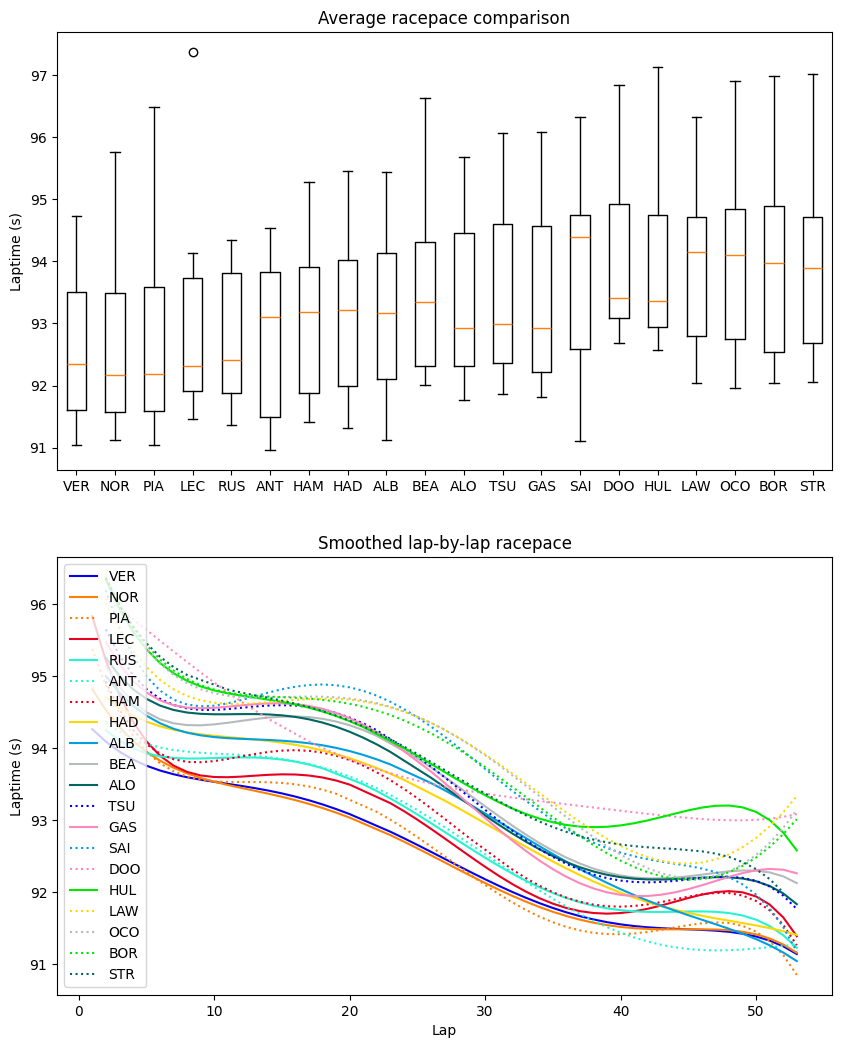

In [44]:
drivers_to_visualize = list(race.results['Abbreviation'])
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []
# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [10, 12.5]
# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)

##############################
#
# Boxplot for average racepace
#
##############################
laptimes = [laps.pick_drivers(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize]

ax[0].boxplot(laptimes, tick_labels=drivers_to_visualize)

ax[0].set_title('Average racepace comparison')
ax[0].set(ylabel = 'Laptime (s)')

##############################
#
# Lap-by-lap racepace comparison
#
##############################
for driver in drivers_to_visualize:
    driver_laps = laps.pick_drivers(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]

    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()

    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]

    # X-coordinate is the lap number
    x = driver_laps['LapNumber']

    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])

    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'

    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.get_team_color(identifier = team, session = race), linestyle=linestyle)

    # Include scatterplot (individual laptimes)
    #y = driver_laps['LapTimeSeconds']
    #scatter_marker = 'o' if team not in visualized_teams else '^'
    #ax[1].scatter(x, y, label=driver, color=ff1.plotting.get_team_color(identifier = team, session = race), marker=scatter_marker)

    # Append labels
    ax[1].set(ylabel = 'Laptime (s)')
    ax[1].set(xlabel = 'Lap')

    # Set title
    ax[1].set_title('Smoothed lap-by-lap racepace')

    # Generate legend
    ax[1].legend()

    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)

    plt.savefig('racepace_comparison.png', dpi=300)

In [46]:
# race strategy
driver_stints = laps[['Driver', 'Stint', 'Compound', 'LapNumber']].groupby(
    ['Driver', 'Stint', 'Compound']
).count().reset_index()
driver_stints = driver_stints.rename(columns={'LapNumber': 'StintLength'})
driver_stints = driver_stints.sort_values(by=['Stint'])

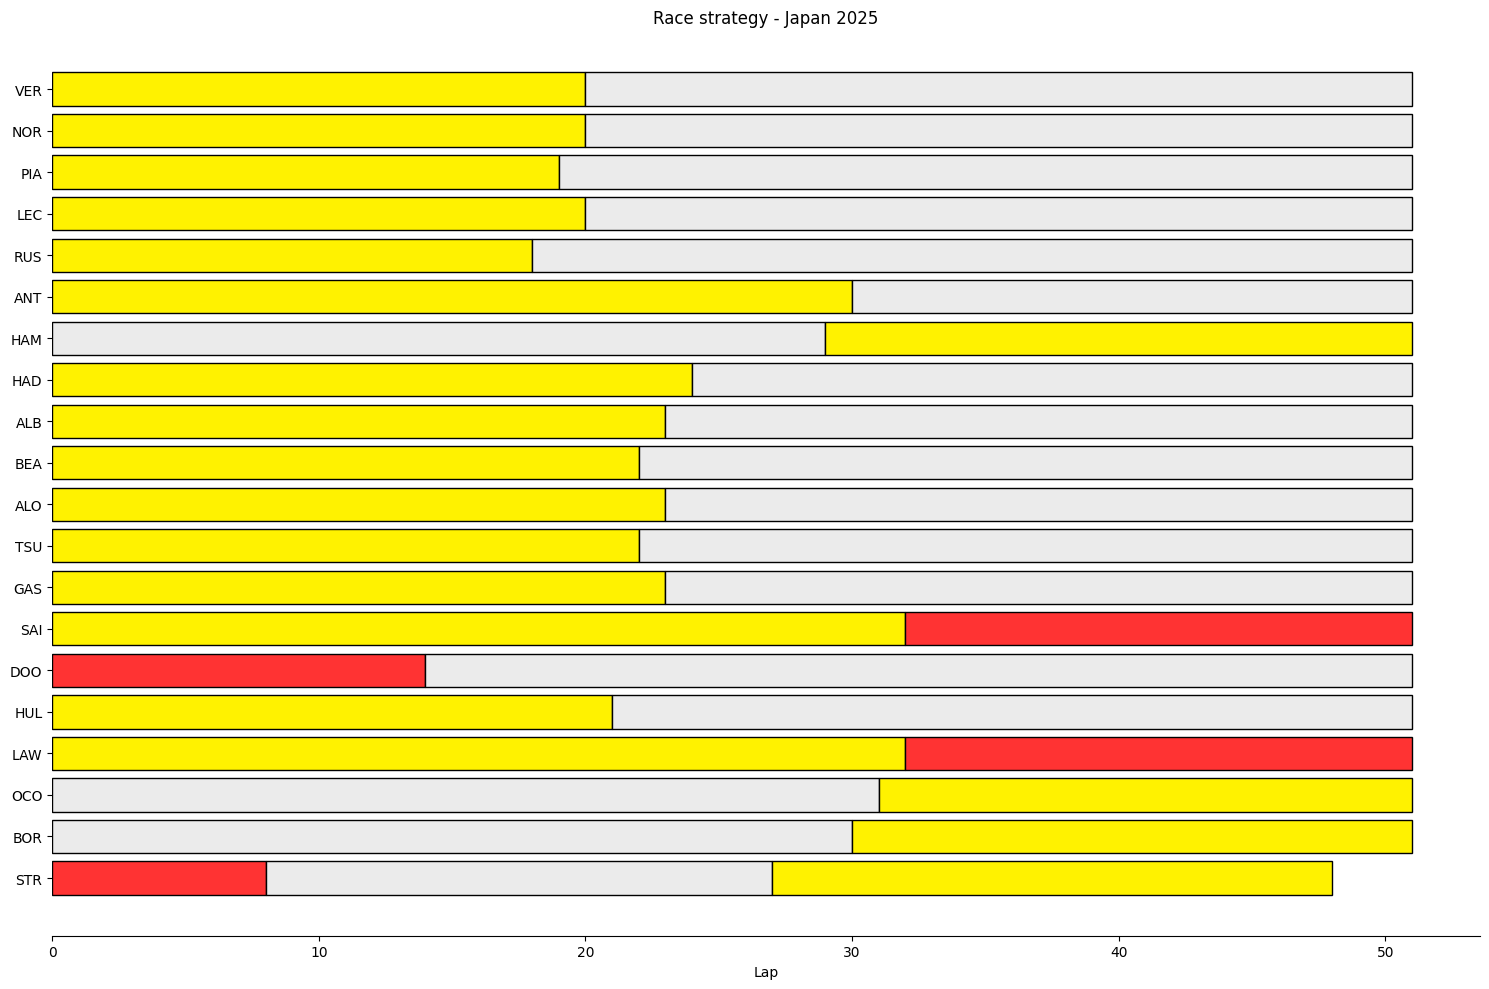

In [47]:
compound_colors = {
    'SOFT': '#FF3333',
    'MEDIUM': '#FFF200',
    'HARD': '#EBEBEB',
    'INTERMEDIATE': '#39B54A',
    'WET': '#00AEEF',
}

plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

for driver in race.results['Abbreviation']:
    stints = driver_stints.loc[driver_stints['Driver'] == driver]

    previous_stint_end = 0
    for _, stint in stints.iterrows():
        plt.barh(
            [driver],
            stint['StintLength'],
            left=previous_stint_end,
            color=compound_colors[stint['Compound']],
            edgecolor = "black"
        )

        previous_stint_end = previous_stint_end + stint['StintLength']

# Set title
plt.title(f'Race strategy - {circuit} {year}')

# Set x-label
plt.xlabel('Lap')

# Invert y-axis
plt.gca().invert_yaxis()

# Remove frame from plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.savefig('strategy_russia.png', dpi=300)

plt.show()